In [ ]:
import os,re
import pandas as pd
import numpy as np
np.random.seed(42)
rng = np.random.default_rng(42)
from collections import namedtuple, OrderedDict
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")


import gensim
from gensim.models import Doc2Vec
from gensim.models import Word2Vec
# from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
from gensim.models.doc2vec import TaggedDocument
import gensim.downloader

from bs4 import BeautifulSoup

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords

#sklearn utilities
from sklearn import utils
from sklearn import feature_extraction
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, f1_score
from sklearn import manifold

#sklearn model types
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

import seaborn as sns
import matplotlib.pyplot as plt

import multiprocessing
cores = multiprocessing.cpu_count()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
modelRoot = './saved_models'
dataRoot = './data'

## First we load, preprocess, and visualize our dataset.

In [ ]:
tmpdf = pd.read_csv(dataRoot + '/data.csv')

In [ ]:
#add a general cateo
df = tmpdf
df['nontoxic'] = ~df[df.keys()[2:8]].any(axis=1)*1
print('% nontoxic: ',np.round(df['nontoxic'].sum()/len(df)*100,3))
df

% nontoxic:  89.832


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,nontoxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,1
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,1
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,1
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,1


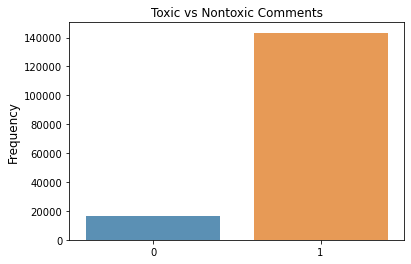

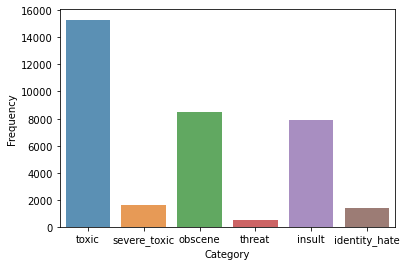

In [ ]:
#visualize the class imbalance
plt.figure()
cnt_pro = df['nontoxic'].value_counts()
sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)
plt.ylabel('Frequency', fontsize=12)
plt.title('Toxic vs Nontoxic Comments')
plt.show();

#visualize the other categories
plt.figure()
subdf = df[df.keys()[2:8]].sum(axis=0)
x = sns.barplot(x=subdf.keys(), y=subdf.values, alpha=0.8)
plt.ylabel('Frequency')
plt.xlabel('Category')
plt.show();

### Our dataset has a significant class imbalance. We may want to reduce this class imbalance by randomly sampling the "nontoxic" comments until we have approximate parity between datasets. Only run this cell if you want to do that.

In [ ]:
subset = rng.integers(low=0,high=len(df),size=(df[df['nontoxic']==0]))
df.iloc[subset]

### Next, we will need a bag of words

In [ ]:
# Define some functions for processing the text and creating the embeddings.

#For leaning up the text a bit, to make it easier on the 
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    text = text.replace('\n', ' ')
    return text

#For creating the bag of words
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens


In [ ]:
#clean up some cruft
df['comment_text'] = df['comment_text'].apply(cleanText)
#split into train/test 
train, test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['nontoxic'])

In [ ]:
#tokenize! 
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['comment_text']), tags=[r.toxic]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['comment_text']), tags=[r.toxic]), axis=1)

In [ ]:
#1 for toxic, 0 for nontoxic.
y_train = ~train['nontoxic'].astype(bool)*1
y_test = ~test['nontoxic'].astype(bool)*1

## Tokens in hand, we can build some features

In [ ]:
#initialize a dict to store our embeddings
embeds = {}
embed = namedtuple('embed', ['X_train', 'X_test'])

### First the naive approach - just counting raw word frequency. 

In [ ]:
svd_components=100
svd = TruncatedSVD(n_components=svd_components, random_state=42)

In [ ]:
# Count (classic BoW)
bow = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))
X_train_bow_sparse = bow.fit_transform(train['comment_text'])
X_test_bow_sparse = bow.fit_transform(test['comment_text'])

In [ ]:
# This matrix is sparse, so let's shrink it down
svd.fit(X_train_bow)
X_train_bow = svd.transform(X_train_bow_sparse)
X_test_bow = svd.transform(X_test_bow_sparse)

In [ ]:
embeds['bow_'+svd_components] = embed(X_train=X_train_bow, X_test=X_test_bow)

### We can get a little more complicated with TF-IDF (Term Frequency - Inverse Document Frequency) 

In [ ]:
tfidf = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf_sparse = tfidf.fit_transform(train['comment_text'])
X_test_tfidf_sparse = tfidf.fit_transform(test['comment_text'])

In [ ]:
svd.fit(X_train_tfidf)
X_train_tfidf = svd.transform(X_train_tfidf_sparse)
X_test_tfidf = svd.transform(X_test_tfidf_sparse)

In [ ]:
embeds['tfidf_'+svd_components] = embed(X_train=X_train_tfidf, X_test=X_test_tfidf)

### Now the less-naive approach, with vector embedding.

In [ ]:
def train_doc2vec(train_tagged,dm=0,num_epochs=30,vector_size=100,root="./"):
    #first create the Doc2Vec object
    model = Doc2Vec(dm=dm, #use the distributed bag of words method
                         vector_size=vector_size, #vector dimension--historically vectors this size are necessary to be useful
                         negative=5, #specifies how many “noise words” should be drawn.
                         hs=0, 
                         min_count=2, #ignore words shorter than 2 characters
                         sample = 0, #the threshold for configuring which higher-frequency words are randomly down sampled.
                         workers=cores)#the threshold for configuring which higher-frequency words are randomly down sampled.
    # and build the vocabulary
    model.build_vocab([x for x in tqdm(train_tagged.values)])
    #now train it
    for epoch in range(num_epochs):
        model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), 
                         total_examples=len(train_tagged.values), 
                         epochs=1)
        model.alpha -= 0.002 #update the learning rate from the default of 0.025
        model.min_alpha = model_dbow.alpha
        
    #save model
    if dm==0:
        filename = "_".join(["model","dbow",str(vector_size)])+".model"
    else:
        filename = "_".join(["model","dbow",str(vector_size)])+".model"        
    model.save("/".join([root,filename]))
    
    return model

def create_embedding(model, tagged_docs):
    X = [model.infer_vector(doc.words) for doc in tagged_docs.values]
    return np.array(X)

In [ ]:
vector_size = 300
#train
model = train_doc2vec(train_tagged,dm=0,num_epochs=30,vector_size=vector_size,root="./saved_models")
#get vectors
X_train_d2v= create_embedding(model, train_tagged)
X_test_d2v = create_embedding(model, test_tagged)
embeds['d2v_'+str(vector_size)] = embed(X_train=X_train_d2v, X_test=X_test_d2v)

In [ ]:
#and one extra pretrained embedding
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

X_train_dmm_300 = create_embedding(model_dmm, train_tagged)
X_test_dmm_300 = create_embedding(model_dmm, test_tagged)
embeds['dmm_300'] = embed(X_train=X_train_dmm_300, X_test=X_test_dmm_300)

### Visualize the embeddings with another nonlinear transform

In [ ]:
def visualize_embeds(embeds,transformer):
    for key in embeds.keys():
        #reduce size, for speed
        reduced_X = embeds[key].X_train[np.random.randint(0,len(X_train),size=1000)]
        #fit
        transformer.fit(reduced_X)
        #split
        nontox = embeds[key].X_train[train['nontoxic']==1]
        tox = embeds[key].X_train[train['nontoxic']==0]
        #randomly sample
        nontox_reduced = nontox[rng.integers(low=0,high=len(nontox),size=int(len(nontox)/50))]
        tox_reduced = tox[rng.integers(low=0,high=len(tox),size=int(len(tox)/50))]
        #transform
        nontox_transform = transformer.transform(nontox_reduced)
        tox_transform = transformer.transform(tox_reduced)
        plt.figure(figsize=(8,6))
        plt.plot(*nontox_transform.T,'o')
        plt.plot(*tox_transform.T,'o')
        plt.title(key)

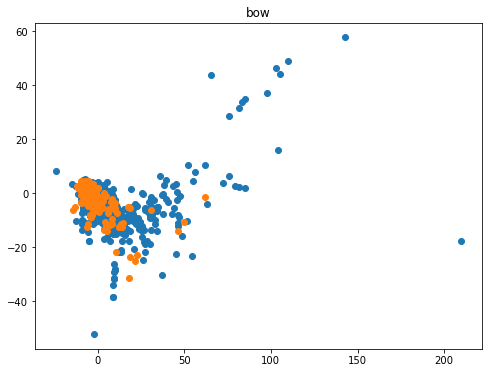

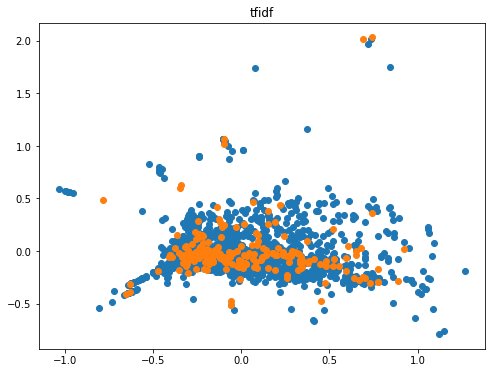

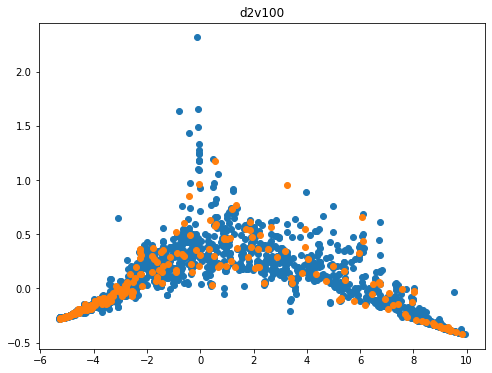

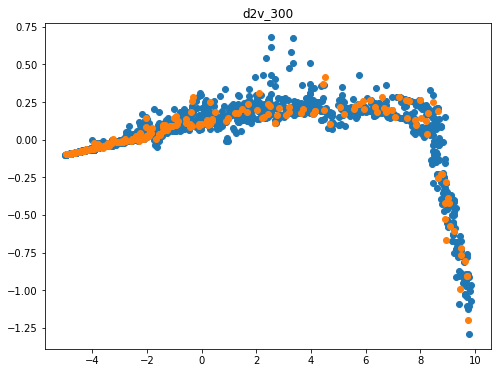

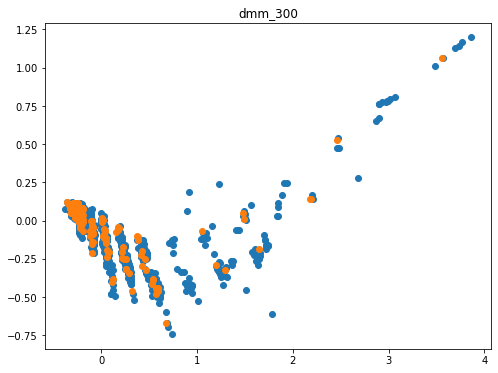

In [ ]:
isomap = Isomap(n_components=2)
visualize_embeds(embeds,isomap)        

## Now we can see how well our embeddings do on various classifiers. We will start with the binary case.

In [ ]:
classifiers = {}
classifiers['Logit'] = LogisticRegression(n_jobs=1, C=1e5,max_iter=1000)
classifiers['NB'] = GaussianNB()
classifiers['SGD'] = SGDClassifier(max_iter=1000,random_state = 42)
classifiers['Perceptron'] = Perceptron(random_state = 42)
classifiers['RF'] = RandomForestClassifier(max_depth=5,random_state = 42)
classifiers['AdaBoost'] = AdaBoostClassifier(random_state = 42)

In [ ]:
metrics = []

for modelKey in classifiers.keys():
    classifier = classifiers[modelKey]    
    print(modelKey)    
    for embedKey in embeds.keys():
        X_train = embeds[embedKey].X_train 
        X_test = embeds[embedKey].X_test

        #fit
        classifier.fit(X_train, y_train)
        #predict
        y_pred = classifier.predict(X_test)
        #score
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        #store metrics, and the trained classifer
        metrics.append([modelKey,embedKey,classifier,acc,f1])
        
        print(embedKey.upper())
        print('Accuracy: %s ' % np.round(acc,3))
        print('F1 score: %s ' % np.round(f1,3))
    print('--------------')
dfmetrics = pd.DataFrame(metrics,columns=['modelKey','embedKey','classifier','acc','f1'])

Logit


C:\Users\julia\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


BOW
Accuracy: 0.683 
F1 score: 0.128 
TFIDF
Accuracy: 0.862 
F1 score: 0.036 
D2V100
Accuracy: 0.9 
F1 score: 0.036 
D2V_300
Accuracy: 0.901 
F1 score: 0.086 
DMM_300
Accuracy: 0.897 
F1 score: 0.234 
--------------
NB
BOW
Accuracy: 0.886 
F1 score: 0.117 
TFIDF
Accuracy: 0.681 
F1 score: 0.257 
D2V100
Accuracy: 0.405 
F1 score: 0.208 
D2V_300
Accuracy: 0.414 
F1 score: 0.211 
DMM_300
Accuracy: 0.271 
F1 score: 0.197 
--------------
SGD
BOW
Accuracy: 0.707 
F1 score: 0.125 
TFIDF
Accuracy: 0.895 
F1 score: 0.008 
D2V100
Accuracy: 0.898 
F1 score: 0.003 
D2V_300
Accuracy: 0.899 
F1 score: 0.004 
DMM_300
Accuracy: 0.898 
F1 score: 0.0 
--------------
Perceptron
BOW
Accuracy: 0.614 
F1 score: 0.153 
TFIDF
Accuracy: 0.869 
F1 score: 0.029 
D2V100
Accuracy: 0.905 
F1 score: 0.259 
D2V_300
Accuracy: 0.903 
F1 score: 0.088 
DMM_300
Accuracy: 0.899 
F1 score: 0.028 
--------------
RF
BOW
Accuracy: 0.874 
F1 score: 0.016 
TFIDF
Accuracy: 0.898 
F1 score: 0.002 
D2V100
Accuracy: 0.909 
F1 score:

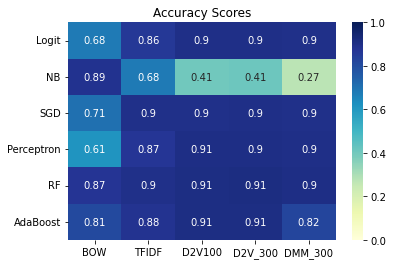

In [ ]:
dfacc = pd.DataFrame(data=np.array(dfmetrics['acc']).reshape(len(classifiers),len(embeds)),
                     columns=[str(key).upper() for key in embeds],
                     index=classifiers.keys(),dtype=float).apply(lambda r: np.round(r,3))
title='Accuracy Scores'
plt.figure()
plt.title(title)
sns.heatmap(dfacc,annot=True,cmap="YlGnBu",vmin=0, vmax=1);

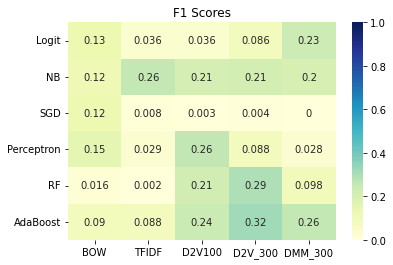

In [ ]:
df1 = pd.DataFrame(data= np.array(dfmetrics['f1']).reshape(len(classifiers),len(embeds)),
                   columns=[str(key).upper() for key in embeds],
                   index=classifiers.keys(),dtype=float).apply(lambda r: np.round(r,3))
title='F1 Scores'
plt.figure()
plt.title(title)
sns.heatmap(df1,annot=True,cmap="YlGnBu",vmin=0, vmax=1);

# By running the following code snippet, we can get rebalanced data, which has 50% toxic comments in train/test sets.

In [ ]:
non_tox = np.sum(df['nontoxic'])
tox = len(df['nontoxic']) - non_tox
remove_n = non_tox - tox
drop_indices = np.random.choice(df['nontoxic'].loc[lambda x: x==1].index, remove_n, replace=False)
df_subset = df.drop(drop_indices)
df = df_subset

### We can see how are the rebalanced data different from the original ones

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:302: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


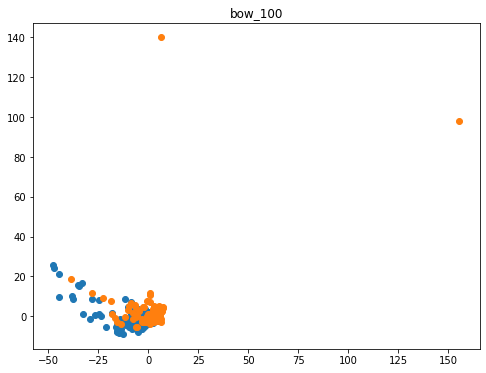

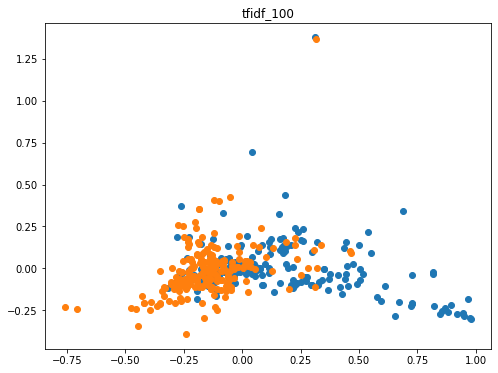

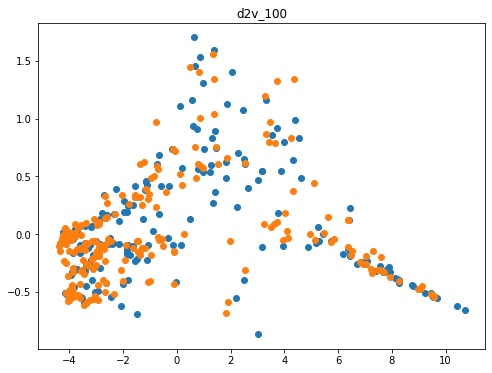

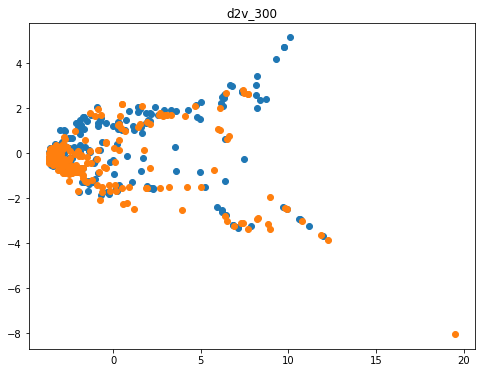

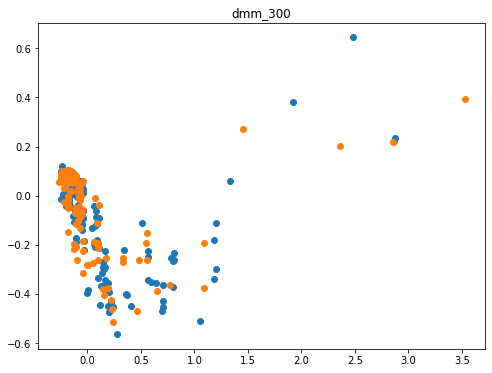

In [ ]:
isomap = manifold.Isomap(n_components=2)
visualize_embeds(embeds,isomap)        

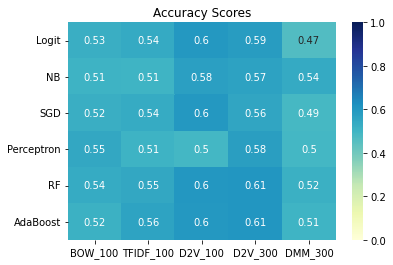

In [ ]:
dfacc = pd.DataFrame(data=np.array(dfmetrics['acc']).reshape(len(classifiers),len(embeds)),
                     columns=[str(key).upper() for key in embeds],
                     index=classifiers.keys(),dtype=float).apply(lambda r: np.round(r,3))
title='Accuracy Scores'
plt.figure()
plt.title(title)
sns.heatmap(dfacc,annot=True,cmap="YlGnBu",vmin=0, vmax=1);

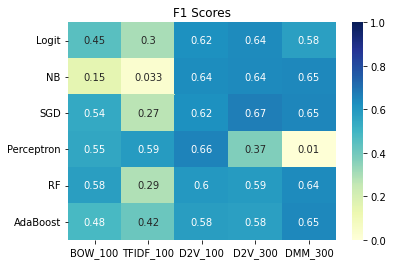

In [ ]:
df1 = pd.DataFrame(data= np.array(dfmetrics['f1']).reshape(len(classifiers),len(embeds)),
                   columns=[str(key).upper() for key in embeds],
                   index=classifiers.keys(),dtype=float).apply(lambda r: np.round(r,3))
title='F1 Scores'
plt.figure()
plt.title(title)
sns.heatmap(df1,annot=True,cmap="YlGnBu",vmin=0, vmax=1);

### Also we tried AutoML to see how it performs

In [ ]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=30
)
automl.fit(X_train_bow, y_train)
y_pred = automl.predict(X_test)
print('Testing accuracy %s' % sklearn.metrics.accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(sklearn.metrics.f1_score(y_test, y_pred)))

Testing accuracy 0.6440677966101694
Testing F1 score: 0.6141855027279813


In [ ]:
y_pred = automl.predict(X_test_bow)
print('Testing accuracy %s' % sklearn.metrics.accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(sklearn.metrics.f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.9042864304812834
Testing F1 score: 0.8588350316038428


In [ ]:
print(automl.show_models())

[(0.840000, SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'gradient_boosting', 'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'no_preprocessing', 'classifier:gradient_boosting:early_stop': 'train', 'classifier:gradient_boosting:l2_regularization': 3.609412172481434e-10, 'classifier:gradient_boosting:learning_rate': 0.05972079854295879, 'classifier:gradient_boosting:loss': 'auto', 'classifier:gradient_boosting:max_bins': 255, 'classifier:gradient_boosting:max_depth': 'None', 'classifier:gradient_boosting:max_leaf_nodes': 4, 'classifier:gradient_boosting:min_samples_leaf': 2, 'classifier:gradient_boosting:scoring': 'loss', 'classifier:gradient_boosting:tol': 1e-07, 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessor:feature_type:num

### Considering that Logit with D2V_300 embedding has a relative good performance. We can take a look at how these comments are classified

In [ ]:
classifiers['Logit'].fit(X_train_d2v, y_train)
y_pred = classifiers['Logit'].predict(X_test_d2v)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# False Negetive
df_array = np.array(test['comment_text'])
print(df_array[np.where((y_test == 1) & (y_pred == 0))][:6])

['"   listen up, you narrow-eyed teacher living on minimum wage   you can keep on doing your ""buck buck"" chicken trash talk, or perhaps you might wanna consider moving back to lemuria - the land where your kind of scum roams."'
 '"  net thing you fuckers will say that those robotic planes in the movie are not called ""hunter killers"" because the movie didn\'t mention their names even though it\'s in the fucking script too. this article is stupid, and just like all the wikipedia jokes, unreliable source for going against official sources.  "'
 'china smells like fart. china smells like fart.china smells like fart.china smells like fart.china smells like fart.china smells like fart.china smells like fart.china smells like fart.china smells like fart.china smells like fart.china smells like fart.china smells like fart.china smells like fart.china smells like fart.china smells like fart.china smells like fart.china smells like fart.china smells like fart.china smells like fart.china sme

In [ ]:
# False Positive
df_array = np.array(test['comment_text'])
print(df_array[np.where((y_test == 0) & (y_pred == 1))][:6])

['" concur, enough said. \'fenian\' "'
 '"held !style=""background: #e3e3e3;""|date won !style=""background: #e3e3e3;""|date ended |- |"'
 'no   assume good faith when an editor is clearly intentionally causing trouble? no thanks, what a waste of time.'
 "i concur with het.this sort of bickering isn't helping the article develop. it's clear as crystal that el doesn't want a link (maybe a personal thing?? who knows) and lk's being a bit ott with his replies ... very cutting & v.ouch! (but v. funny!) is he a real lord? who cares!the link looks good and meets the relevance policy.have also looked up el's page and yes el, you have been getting your own page editors to support this argument. naughty gal ;-) now children go and play nicely!"
 'use your tongue to paint my boat!'
 'sorry, someone just opposed your nom at wp:itn/c, you will have to discuss with him first...']


In [ ]:
# True Positive
df_array = np.array(test['comment_text'])
print(df_array[np.where((y_test == 1) & (y_pred == 1))][:6])

['"   you enjoy picking your nose and then wiping on your math book.   that\'s disgusting, dude.  —preceding unsigned comment added by 74.12.98.184   "'
 'shut up, you button!'
 'ecirial you are a joke - do not piss me off remove the block'
 'fyi i enjoy licking strangers scrotal sacks...especially hairy ones. yum.'
 'stupid   this is stupid. does anyone agree?'
 "yo mama's so fat that when she jump for joy she got stuck!"]


In [ ]:
# True Negative
df_array = np.array(test['comment_text'])
print(df_array[np.where((y_test == 0) & (y_pred == 0))][:6])

['"   some wikipedia ""contributors"" giving the dictator jose eduardo dos santos an engineer degree in petroleum   some wikipedia ""contributors"" giving the dictator jose eduardo dos santos an engineer degree in petroleum  this section is taken out from the propaganda web page of the mpla peoples party (communist party). looking at the dates there is no chance that mr. jose eduardo dos santos could have gone to russia for a oil engineer degree. also the mpla official web page does not mentions any such degree as well. taking into consideration that this would be considered a major achievement it seems odd to say the least that the mpla comrades totalitarian party have ""forgotten"" to mention this intellectual and academic achievement of their murderous and deep ignorant leader.  but in wikipedia from (night to day) ""voila"" mr. jose eduardo dos santos (a son of a sao tome brick layer) could not have gone to russia or timbuktu for a degree, as it was economical impossible to him to 